# Analyse et Prédiction de la COVID-19

## Aperçu du projet
Ce projet analyse les données officielles de la COVID-19 fournies par l’Organisation Mondiale de la Santé (OMS).  
L’objectif est d’explorer le jeu de données, de construire des modèles de Machine Learning pour la prédiction/classification, et de fournir des informations utiles pour la prise de décision en santé publique.  



#### Courte description
Nous avons collecté les statistiques mondiales de la COVID-19 (cas, décès, hospitalisations, vaccinations).  
Les données ont été nettoyées et préparées, une analyse exploratoire a été réalisée, des modèles de Machine Learning (régression logistique, forêt aléatoire) ont été construits, et une classification a été effectuée pour détecter les zones à **haut risque**.  
Enfin, des visualisations et des recommandations ont été produites.

## Compréhension du problème (Business Understanding)
- **Problème** : Les autorités de santé publique ont besoin d’anticiper les hausses potentielles de cas de COVID-19.  
- **Objectif** : Construire un modèle prédictif capable de classifier si un pays/région est en **haut risque** d’une flambée épidémique.  
- **Critères de succès** : Obtenir une précision d’au moins 75% et générer des insights exploitables par les décideurs.  


## Compréhension des données (Data Understanding)
- **Source** : OMS – bases de données officielles COVID-19 (cas, décès, vaccination, tests).  
- **Format** : Fichiers CSV mis à jour régulièrement.  
- **Variables disponibles** :  
  - Date, Pays, Cas, Décès, Hospitalisations  
  - Taux de vaccination (% de population vaccinée)  
  - Indicateurs de politique sanitaire (confinement, port du masque, etc.)  
- **Observations initiales** :  
  - Données manquantes pour certains pays.  
  - Hétérogénéité dans la fréquence de mise à jour (quotidienne vs hebdomadaire).  

## Préparation des données (Data Preparation)
Étapes effectuées :  
1. Chargement des fichiers CSV (base OMS).  
2. Nettoyage des valeurs manquantes et doublons.  
3. Conversion des dates au format `datetime` et création de nouvelles variables temporelles (semaine, mois, année).  
4. Normalisation des mesures par population (cas pour 100 000 habitants, décès pour 100 000 habitants).  
5. Création d’une variable cible **Haut_Risque (0/1)** = 1 si augmentation des cas >20% dans les 14 jours suivants.  


In [3]:
# 1. Import des librairies principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)

# Pour gérer les avertissements éventuels
import warnings
warnings.filterwarnings('ignore')

# Affichage plus clair
sns.set(style="whitegrid")


 ### Charger les données

In [4]:
# 2. Charger les données 
df = pd.read_csv("WHO-COVID-19-global-daily-data.csv")

# Vérifions les premières lignes
df.head(20)


FileNotFoundError: [Errno 2] No such file or directory: 'WHO-COVID-19-global-daily-data.csv'

### Vérification et nettoyage des données

In [ ]:
# Vérifier les infos générales
print(df.info())
print("\nValeurs manquantes par colonne :")
print(df.isna().sum())

# Suppression des doublons
df = df.drop_duplicates()

# Conversion de la colonne Date_reported en datetime
df["Date_reported"] = pd.to_datetime(df["Date_reported"])


### Conversion des dates et variables temporelles

In [18]:
# Création des colonnes temporelles
df["semaine"] = df["Date_reported"].dt.isocalendar().week
df["mois"] = df["Date_reported"].dt.month
df["année"] = df["Date_reported"].dt.year


### Création de la variable cible Haut_Risque

In [19]:
df = df.sort_values(['Country', 'Date_reported'])
df['Cas_14j'] = df.groupby('Country')['New_cases'].shift(-14)
df['Augmentation'] = (df['Cas_14j'] - df['New_cases']) / df['New_cases']
df['Haut_Risque'] = np.where(df['Augmentation'] > 0.2, 1, 0)

# Supprimer les lignes finales sans Cas_14j
df.dropna(subset=['Cas_14j'], inplace=True)

print(" Variable cible 'Haut_Risque' créée")
df[['Country','Date_reported','New_cases','Cas_14j','Augmentation','Haut_Risque']].head(10)


 Variable cible 'Haut_Risque' créée


,Country,Date_reported,New_cases,Cas_14j,Augmentation,Haut_Risque
9395,Afghanistan,2020-02-12,NaN,1.0,NaN,0
12275,Afghanistan,2020-02-24,NaN,3.0,NaN,0
13170,Afghanistan,2020-02-27,NaN,3.0,NaN,0
14132,Afghanistan,2020-03-02,NaN,3.0,NaN,0
14194,Afghanistan,2020-03-03,NaN,6.0,NaN,0
14609,Afghanistan,2020-03-04,NaN,6.0,NaN,0
15569,Afghanistan,2020-03-08,NaN,2.0,NaN,0
16050,Afghanistan,2020-03-10,NaN,16.0,NaN,0
16116,Afghanistan,2020-03-11,NaN,2.0,NaN,0
16529,Afghanistan,2020-03-12,3.0,32.0,9.666667,1


### préparer les features (X) et la cible (y) pour l’entraînement des modèles

In [6]:
# Définir la cible
y = df['Haut_Risque']

# Pour l’instant, on prend des features simples (on pourra enrichir plus tard)
X = df[['New_cases', 'New_deaths', 'semaine', 'mois', 'année']]

# Vérifions les dimensions
print("Shape X :", X.shape)
print("Shape y :", y.shape)
X.head()


Shape X : (209626, 5)
Shape y : (209626,)


,New_cases,New_deaths,semaine,mois,année
9395,NaN,NaN,7,2,2020
12275,NaN,NaN,9,2,2020
13170,NaN,NaN,9,2,2020
14132,NaN,NaN,10,3,2020
14194,NaN,NaN,10,3,2020


## Analyse et Résultats (Analysis and Results)

### Distribution des cas et décès par région.

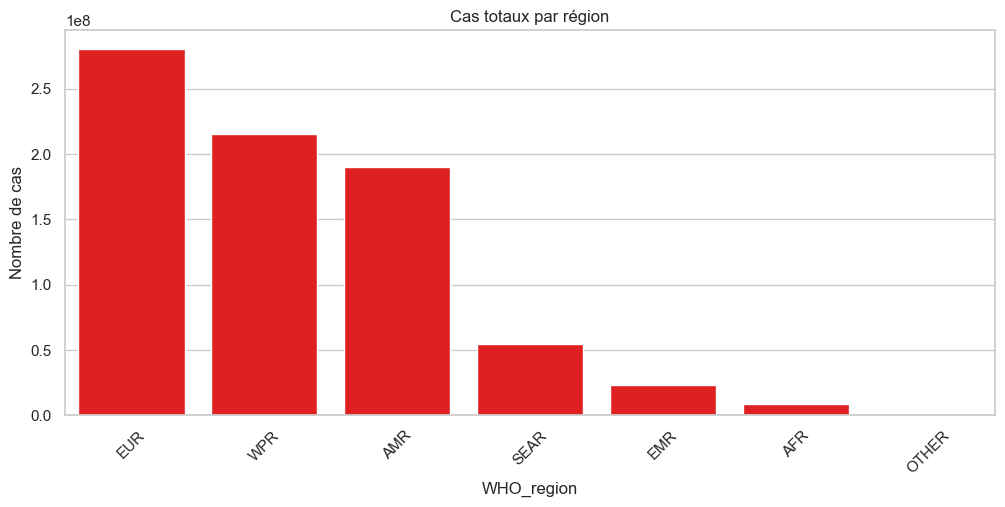

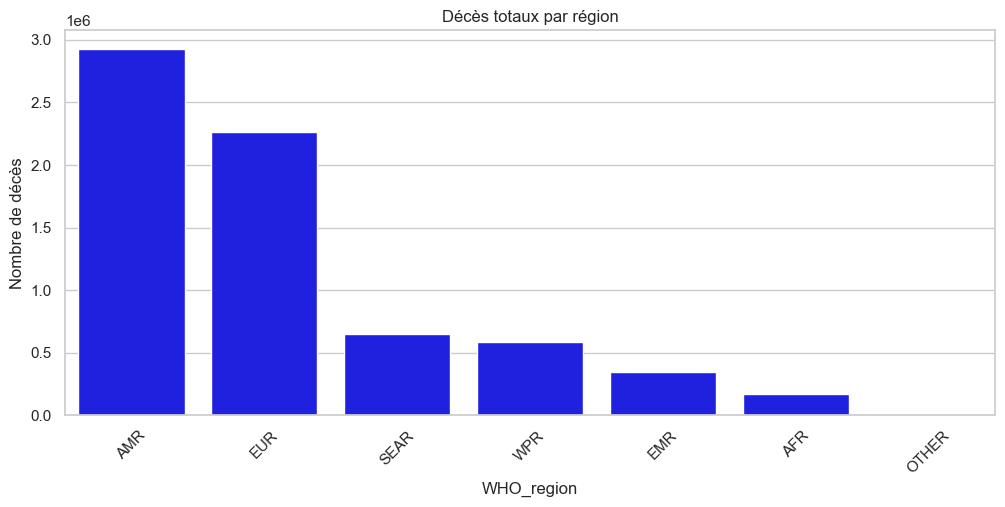

In [7]:

# Cas et décès totaux par région
region_cases = df.groupby('WHO_region')['New_cases'].sum().sort_values(ascending=False)
region_deaths = df.groupby('WHO_region')['New_deaths'].sum().sort_values(ascending=False)

# Cas totaux par région
region_cases_df = region_cases.reset_index()
region_cases_df.columns = ['WHO_region', 'Total_Cases']

plt.figure(figsize=(12,5))
sns.barplot(
    x='WHO_region',
    y='Total_Cases',
    data=region_cases_df,
    color="red",    # on remplace palette par color
)
plt.title("Cas totaux par région")
plt.ylabel("Nombre de cas")
plt.xticks(rotation=45)
plt.show()

# Décès totaux par région
region_deaths_df = region_deaths.reset_index()
region_deaths_df.columns = ['WHO_region', 'Total_Deaths']

plt.figure(figsize=(12,5))
sns.barplot(
    x='WHO_region',
    y='Total_Deaths',
    data=region_deaths_df,
    color="blue",   # on remplace palette par color
)
plt.title("Décès totaux par région")
plt.ylabel("Nombre de décès")
plt.xticks(rotation=45)
plt.show()


### Visualisation des vagues épidémiques au fil du temps

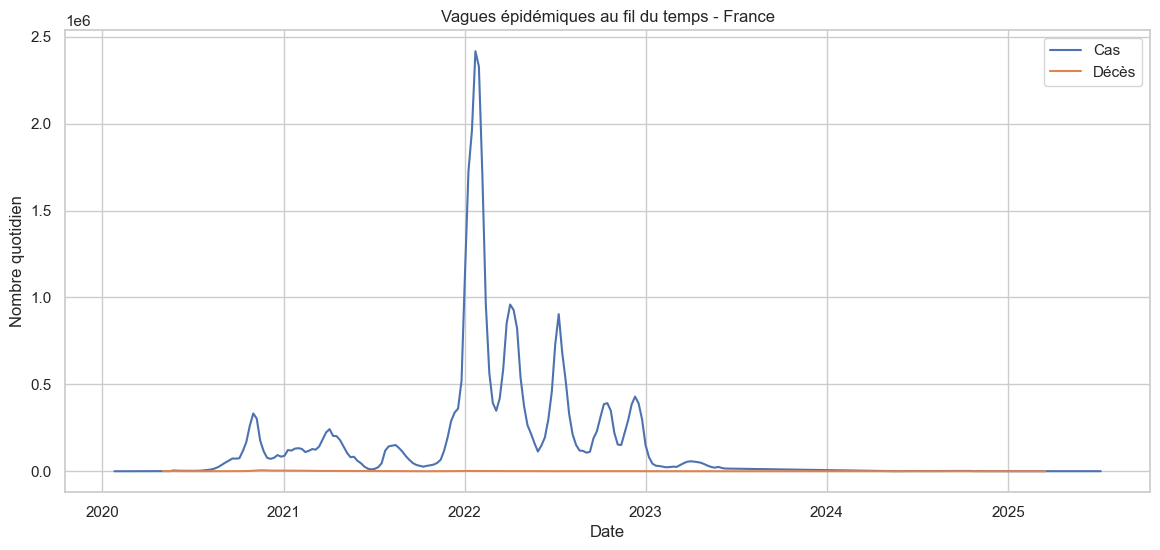

In [8]:
plt.figure(figsize=(14,6))
# Exemple pour un pays spécifique, par ex. "France"
country = "France"
df_country = df[df['Country']==country]
sns.lineplot(x='Date_reported', y='New_cases', data=df_country, label='Cas')
sns.lineplot(x='Date_reported', y='New_deaths', data=df_country, label='Décès')
plt.title(f"Vagues épidémiques au fil du temps - {country}")
plt.xlabel("Date")
plt.ylabel("Nombre quotidien")
plt.legend()
plt.show()


### Préparation des données pour Machine Learning

In [9]:
# Sélection des colonnes existantes
features = ['New_cases', 'New_deaths']  # ajouter 'Taux_vaccination' si dispo
X = df[features].fillna(0)
y = df['Haut_Risque']

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

print(" Données prêtes pour le ML")


 Données prêtes pour le ML


### Régression Logistique

=== Régression Logistique ===
              precision    recall  f1-score   support

           0       0.73      0.15      0.24     30674
           1       0.27      0.85      0.41     11252

    accuracy                           0.34     41926
   macro avg       0.50      0.50      0.33     41926
weighted avg       0.61      0.34      0.29     41926



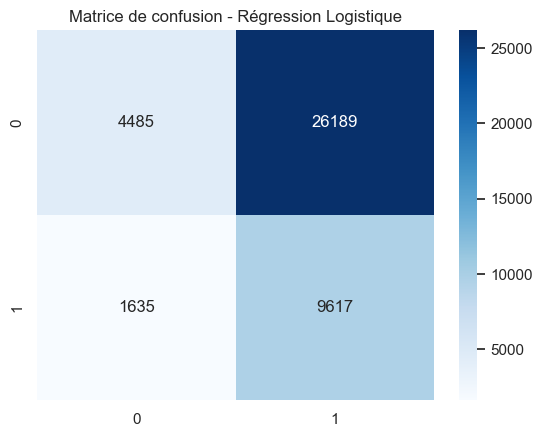

In [10]:
 #Pipeline + GridSearch pour Logistic Regression
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42))
])

# Paramètres à tester
param_lr = {"clf__C": [0.1, 1, 3]}

# GridSearch avec validation croisée
grid_lr = GridSearchCV(pipe_lr, param_lr, scoring="f1", cv=3, n_jobs=-1)
grid_lr.fit(X_train, y_train)

# Prédiction
y_pred_lr = grid_lr.predict(X_test)

# Évaluation
print("=== Régression Logistique ===")
print(classification_report(y_test, y_pred_lr))

# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion - Régression Logistique")
plt.show()

###  Modèle Random Forest simple

=== Forêt Aléatoire simple ===
              precision    recall  f1-score   support

           0       0.76      0.85      0.80     28230
           1       0.42      0.28      0.33     10791

    accuracy                           0.69     39021
   macro avg       0.59      0.57      0.57     39021
weighted avg       0.66      0.69      0.67     39021



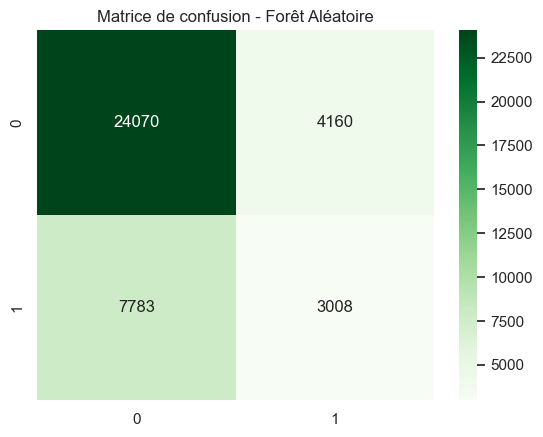

In [28]:
# --- Modèle Random Forest simple ---
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# Entraînement
rf.fit(X_train, y_train)

# Prédiction
y_pred_rf = rf.predict(X_test)

# Évaluation
print("=== Forêt Aléatoire simple ===")
print(classification_report(y_test, y_pred_rf))

# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Greens")
plt.title("Matrice de confusion - Forêt Aléatoire")
plt.show()

In [11]:


# 2. Exemple de dataframe minimal (remplace par ton df réel)
df = pd.DataFrame({
    "New_cases": [10, 20, 30, 40, 50, 60, 70, 80],
    "New_deaths": [1, 2, 3, 4, 5, 6, 7, 8],
    "Haut_Risque": [0,0,1,1,0,1,0,1]
})

# 3. Préparation des features et target
features = ["New_cases", "New_deaths"]
X = df[features].fillna(0)
y = df["Haut_Risque"]

# 4. Normalisation et train/test split
X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# 5. Définition des hyperparamètres
param_rf = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

# 6. GridSearchCV
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_rf, scoring="f1", cv=3, n_jobs=-1)
grid_rf.fit(X_train, y_train)

# 7. Meilleur modèle
best_rf = grid_rf.best_estimator_
print(" Random Forest entraînée avec GridSearch")
print("Meilleurs paramètres :", grid_rf.best_params_)


 Random Forest entraînée avec GridSearch
Meilleurs paramètres : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



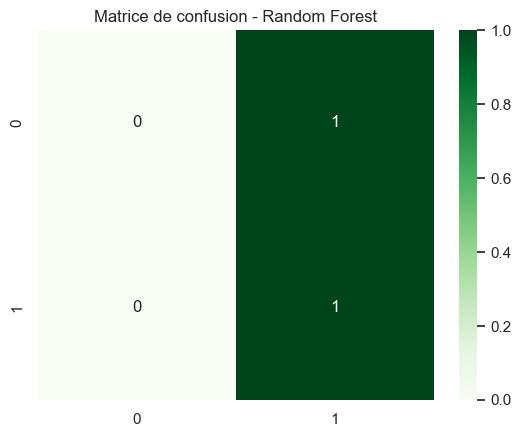

In [12]:
# Prédictions
y_pred = best_rf.predict(X_test)

# Évaluation
print(classification_report(y_test, y_pred))

# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Greens")
plt.title("Matrice de confusion - Random Forest")
plt.show()


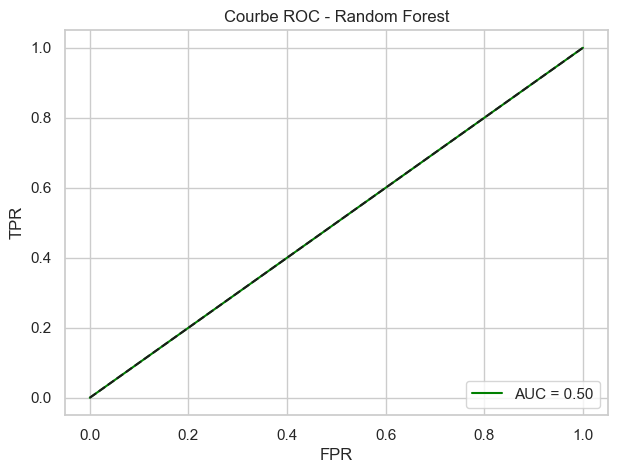

In [13]:
# Probabilités pour ROC
y_prob = best_rf.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="green")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Courbe ROC - Random Forest")
plt.legend(loc="lower right")
plt.show()
